#### Across various spatial resolution i.e `N_LAT = 64 to 128`

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import lib.plots.neuralfield
import matplotlib.pyplot as plt
import numpy as np
import lib.model.neuralfield

2022-10-05 09:58:35.702677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 09:58:35.706318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 09:58:35.706444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
def find_onsets(ts, thrshld):
    nt, nn = ts.shape
    onsets = (nt + 50)*np.ones(nn)
    for i in range(nn):
        ts_i_thrshd = ts[:,i] > thrshld
        if(ts_i_thrshd.any()):
            onsets[i] = np.nonzero(ts_i_thrshd)[0][0]
        else:
            onsets[i] = np.inf
    return onsets

def find_ez(x, src_thrshld, onst_wndw_sz):
    nt, nn = x.shape
    onsets = find_onsets(x, src_thrshld)
    nszng = np.size(np.nonzero(onsets < nt))
    assert nszng > 0, "No seizing regions found"
    first_onset_time = onsets.min()
    ez_pred = np.zeros(nn)
    onst_thrshld = first_onset_time + onst_wndw_sz
    ez_pred[np.nonzero(onsets <= onst_thrshld)[0]] = 1
    pz_pred = np.zeros(nn)
    pz_pred[np.nonzero(np.logical_and(onsets > onst_thrshld, onsets < nt))[0]] = 1
    return ez_pred, pz_pred

def precision_recall(ez_hyp, ez_pred):
    tp = fp = fn = 0
    for a, b in zip(ez_hyp, ez_pred):
        if(a == 1 and b == 1):
            tp += 1
        elif(a == 1 and b == 0):
            fn += 1
        elif(a == 0 and b == 1):
            fp += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

In [3]:
data_dir = 'datasets/syn_data/id004_bj/LMAX_lc_32'
L_MAX = 32
L_MAX_PARAMS = 16

In [3]:
ez_pred = {}
pz_pred = {}
for N_LAT in range(64, 129):
    N_LON = 2 * N_LAT
    # Find the best MAP estimate
    losses = []
    for i in range(1, 11):
        map_estim = np.load(f'results/exp87.1/res_N_LAT{N_LAT:d}_run{i:d}.npz')
        l = map_estim['losses'][-1,0]
        if np.isnan(l):
            l = np.inf
        losses.append(l)
    best_map_run = np.argmin(losses) + 1
    print(f"NLAT={N_LAT} run={best_map_run} loss={losses[best_map_run-1]}")

    # Compute precision recall for the best MAP estimate
    map_estim = np.load(f'results/exp87.1/res_N_LAT{N_LAT:d}_run{best_map_run:d}.npz')
    theta = map_estim['theta']
    dyn_mdl = lib.model.neuralfield.Epileptor2D(
        L_MAX=L_MAX,
        N_LAT=N_LAT,
        N_LON=N_LON,
        verts_irreg_fname=f"{data_dir}/vertices.txt",
        rgn_map_irreg_fname=f"{data_dir}/Cortex_region_map_ico7.txt",
        conn_zip_path=f"{data_dir}/connectivity.vep.zip",
        gain_irreg_path=f"{data_dir}/gain_inv_square_ico7.npz",
        gain_irreg_rgn_map_path=f"{data_dir}/gain_region_map_ico7.txt",
        L_MAX_PARAMS=L_MAX_PARAMS,
        diff_coeff=0.00047108,
        alpha=2.0,
        theta=-1.0)

    sim_data = np.load(f'{data_dir}/sim_N_LAT{N_LAT}.npz')
    ez_hyp_roi = [
        dyn_mdl.roi_map_tvb_to_tfnf[roi] for roi in sim_data['ez_roi_tvb']
    ]
    ez_hyp_vrtcs = np.concatenate(
        [np.nonzero(roi == dyn_mdl.rgn_map)[0] for roi in ez_hyp_roi])
    dyn_mdl.SC = tf.constant(sim_data['SC'], dtype=tf.float32)

    x0_prior_mu = -3.0 * np.ones(dyn_mdl.nv + dyn_mdl.ns)
    x0_prior_mu[ez_hyp_vrtcs] = -1.5
    x0_prior_mu = tf.constant(x0_prior_mu, dtype=tf.float32)
    x0_prior_std = 0.5 * tf.ones(dyn_mdl.nv + dyn_mdl.ns)
    x_init_prior_mu = -3.0 * tf.ones(dyn_mdl.nv + dyn_mdl.ns)
    z_init_prior_mu = 5.0 * tf.ones(dyn_mdl.nv + dyn_mdl.ns)

    mean = {
        'x0': x0_prior_mu,
        'x_init': x_init_prior_mu,
        'z_init': z_init_prior_mu,
        'eps': 0.1,
        'K': 1.0
    }
    std = {
        'x0': x0_prior_std,
        'x_init': 0.5,
        'z_init': 0.5,
        'eps': 0.1,
        'K': 5
    }

    dyn_mdl.setup_inference(nsteps=300,
                            nsubsteps=2,
                            time_step=tf.constant(0.05, dtype=tf.float32),
                            mean=mean,
                            std=std,
                            obs_data=sim_data['slp_aug'],
                            param_space='mode',
                            obs_space='sensor')
    (x0_hat_l_m, x_init_hat_l_m, z_init_hat_l_m, eps_hat, K_hat, tau_hat,
        amp_hat, offset_hat) = dyn_mdl.split_params(theta)
    (x0_pred, x_init_pred, z_init_pred, eps_pred, K_pred, tau_pred,
        amp_pred,
        offset_pred) = dyn_mdl.transformed_parameters(x0_hat_l_m,
                                                    x_init_hat_l_m,
                                                    z_init_hat_l_m,
                                                    eps_hat,
                                                    K_hat,
                                                    tau_hat,
                                                    amp_hat,
                                                    offset_hat,
                                                    param_space='mode')
    x0_pred_masked = x0_pred * dyn_mdl.unkown_roi_mask
    y_init_pred = tf.concat((x_init_pred * dyn_mdl.unkown_roi_mask,
                                z_init_pred * dyn_mdl.unkown_roi_mask),
                            axis=0)
    y_pred = dyn_mdl.simulate(dyn_mdl.nsteps, dyn_mdl.nsubsteps,
                                dyn_mdl.time_step, y_init_pred,
                                x0_pred * dyn_mdl.unkown_roi_mask, tau_pred,
                                K_pred)
    x_pred = y_pred[:, 0:dyn_mdl.nv + dyn_mdl.ns] * dyn_mdl.unkown_roi_mask
    slp_pred = amp_pred * dyn_mdl.project_sensor_space(
        x_pred) + offset_pred
    x_tmp = x_pred.numpy()
    x_tmp[:, dyn_mdl._unkown_roi_idcs] = -3.0
    ez_pred[f'N_LAT{N_LAT:d}'] = {}
    pz_pred[f'N_LAT{N_LAT:d}'] = {}
    for ows in range(5, 30):
        ez, pz = find_ez(x_tmp, 0.0, ows)
        ez_pred[f'N_LAT{N_LAT:d}'][f'OWS{ows:d}'] = ez
        pz_pred[f'N_LAT{N_LAT:d}'][f'OWS{ows:d}'] = pz
np.savez(f'results/exp87.1/ez_pz_pred.npz', ez_pred=ez_pred, pz_pred=pz_pred)

NLAT=64 run=5 loss=-169118.84375


2022-10-05 08:33:50.879137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 08:33:50.880043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 08:33:50.880325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 08:33:50.880538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region


2022-10-05 08:33:59.402450: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x36fb18d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-05 08:33:59.402479: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Quadro RTX 4000 with Max-Q Design, Compute Capability 7.5
2022-10-05 08:33:59.481756: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-10-05 08:34:00.160559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-10-05 08:34:00.611962: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=65 run=9 loss=-176793.953125
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=66 run=7 loss=-28639.5859375
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region


2022-10-05 08:34:27.180087: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=67 run=4 loss=-176932.90625
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=68 run=1 loss=-18193.75
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=69 run=4 loss=-195078.796875
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=70 run=9 loss=-199310.625
Assuming indices (zero based) of 

2022-10-05 08:38:17.754332: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=83 run=1 loss=-261067.125
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=84 run=2 loss=-267697.9375
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=85 run=4 loss=-276706.59375
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=86 run=5 loss=-271708.4375
Assuming indices (zero based) of

2022-10-05 08:40:29.147638: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=91 run=5 loss=-310595.125
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=92 run=5 loss=-296153.96875
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=93 run=3 loss=-330934.0
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=94 run=10 loss=-306664.15625
Assuming indices (zero based) of 

2022-10-05 08:41:38.569234: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=95 run=7 loss=-332466.34375
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=96 run=7 loss=-349632.0625
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=97 run=6 loss=-345298.28125
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=98 run=8 loss=-361229.78125
Assuming indices (zero based)

2022-10-05 08:42:51.913042: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=99 run=7 loss=-365959.375
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=100 run=2 loss=-364712.46875
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region


2022-10-05 08:43:29.525082: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=101 run=10 loss=-201509.140625
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=102 run=7 loss=-370928.625
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region


2022-10-05 08:44:07.687753: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=103 run=10 loss=-383896.71875
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=104 run=5 loss=-392775.34375
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region


2022-10-05 08:44:46.923324: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=105 run=4 loss=-392555.375
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=106 run=5 loss=-404080.625
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region


2022-10-05 08:45:26.530318: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=107 run=4 loss=-413393.875
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=108 run=5 loss=-409256.09375
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=109 run=7 loss=-390099.96875
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=110 run=4 loss=-430234.53125
Assuming indices (zero bas

2022-10-05 08:48:11.738700: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=115 run=10 loss=-474782.5
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=116 run=5 loss=-469577.21875
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=117 run=9 loss=-441787.65625
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=118 run=6 loss=-499129.75
Assuming indices (zero based) 

2022-10-05 08:51:04.271804: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=123 run=3 loss=-529526.125
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=124 run=9 loss=-531010.0
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=125 run=2 loss=-547546.0
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=126 run=7 loss=-546335.125
Assuming indices (zero based) of sub

2022-10-05 08:52:36.645335: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=127 run=2 loss=-540866.125
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...
NLAT=128 run=4 loss=-562355.1875
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region


2022-10-05 08:53:24.066659: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_6'



euler_integrator()...
epileptor2d_nf_ode_fn()...
local_coupling()...


In [4]:
precision = {}
recall = {}
ez_pred = np.load('results/exp87.1/ez_pz_pred.npz',
                  allow_pickle=True)['ez_pred'][()]
for N_LAT in range(64, 129):
    N_LON = 2 * N_LAT
    dyn_mdl = lib.model.neuralfield.Epileptor2D(
        L_MAX=L_MAX,
        N_LAT=N_LAT,
        N_LON=N_LON,
        verts_irreg_fname=f"{data_dir}/vertices.txt",
        rgn_map_irreg_fname=f"{data_dir}/Cortex_region_map_ico7.txt",
        conn_zip_path=f"{data_dir}/connectivity.vep.zip",
        gain_irreg_path=f"{data_dir}/gain_inv_square_ico7.npz",
        gain_irreg_rgn_map_path=f"{data_dir}/gain_region_map_ico7.txt",
        L_MAX_PARAMS=L_MAX_PARAMS,
        diff_coeff=0.00047108,
        alpha=2.0,
        theta=-1.0)

    sim_data = np.load(f'{data_dir}/sim_N_LAT{N_LAT:d}.npz')
    ez_hyp_roi = [
        dyn_mdl.roi_map_tvb_to_tfnf[roi] for roi in sim_data['ez_roi_tvb']
    ]
    ez_hyp_vrtcs = np.concatenate(
        [np.nonzero(roi == dyn_mdl.rgn_map)[0] for roi in ez_hyp_roi])
    _ez_hyp = np.zeros_like(sim_data['x0'])
    _ez_hyp[ez_hyp_vrtcs] = 1

    precision[f'N_LAT{N_LAT}'] = {}
    recall[f'N_LAT{N_LAT}'] = {}
    for ows in range(5, 30):
        _ez_pred = ez_pred[f'N_LAT{N_LAT:d}'][f'OWS{ows:d}']
        p, r = precision_recall(ez_hyp=_ez_hyp, ez_pred=_ez_pred)
        precision[f'N_LAT{N_LAT}'][f'OWS{ows}'] = p
        recall[f'N_LAT{N_LAT}'][f'OWS{ows}'] = r
np.savez(f'results/exp87.1/precision_recall.npz',
         precision=precision,
         recall=recall)


2022-10-05 09:58:43.197532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 09:58:43.199283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 09:58:43.199458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 09:58:43.199558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
Assuming indices (zero based) of subcortical roi in the provided SC to be [73:81] for left hemisphere and [154:162] for right hemisphere
Assuming ROI 0 in provided SC is the UNKOWN region
Assuming indices (zero based) of subcortical roi in the prov

In [12]:
precision = np.load('results/exp87.1/precision_recall.npz', allow_pickle=True)['precision'][()]
recall = np.load('results/exp87.1/precision_recall.npz', allow_pickle=True)['recall'][()]
p = [list(precision[f'N_LAT{N_LAT:d}'].values()) for N_LAT in range(64,129)]
r = [list(recall[f'N_LAT{N_LAT:d}'].values()) for N_LAT in range(64,129)]
res = (np.r_[64:129]) * (2 * np.r_[64:129])

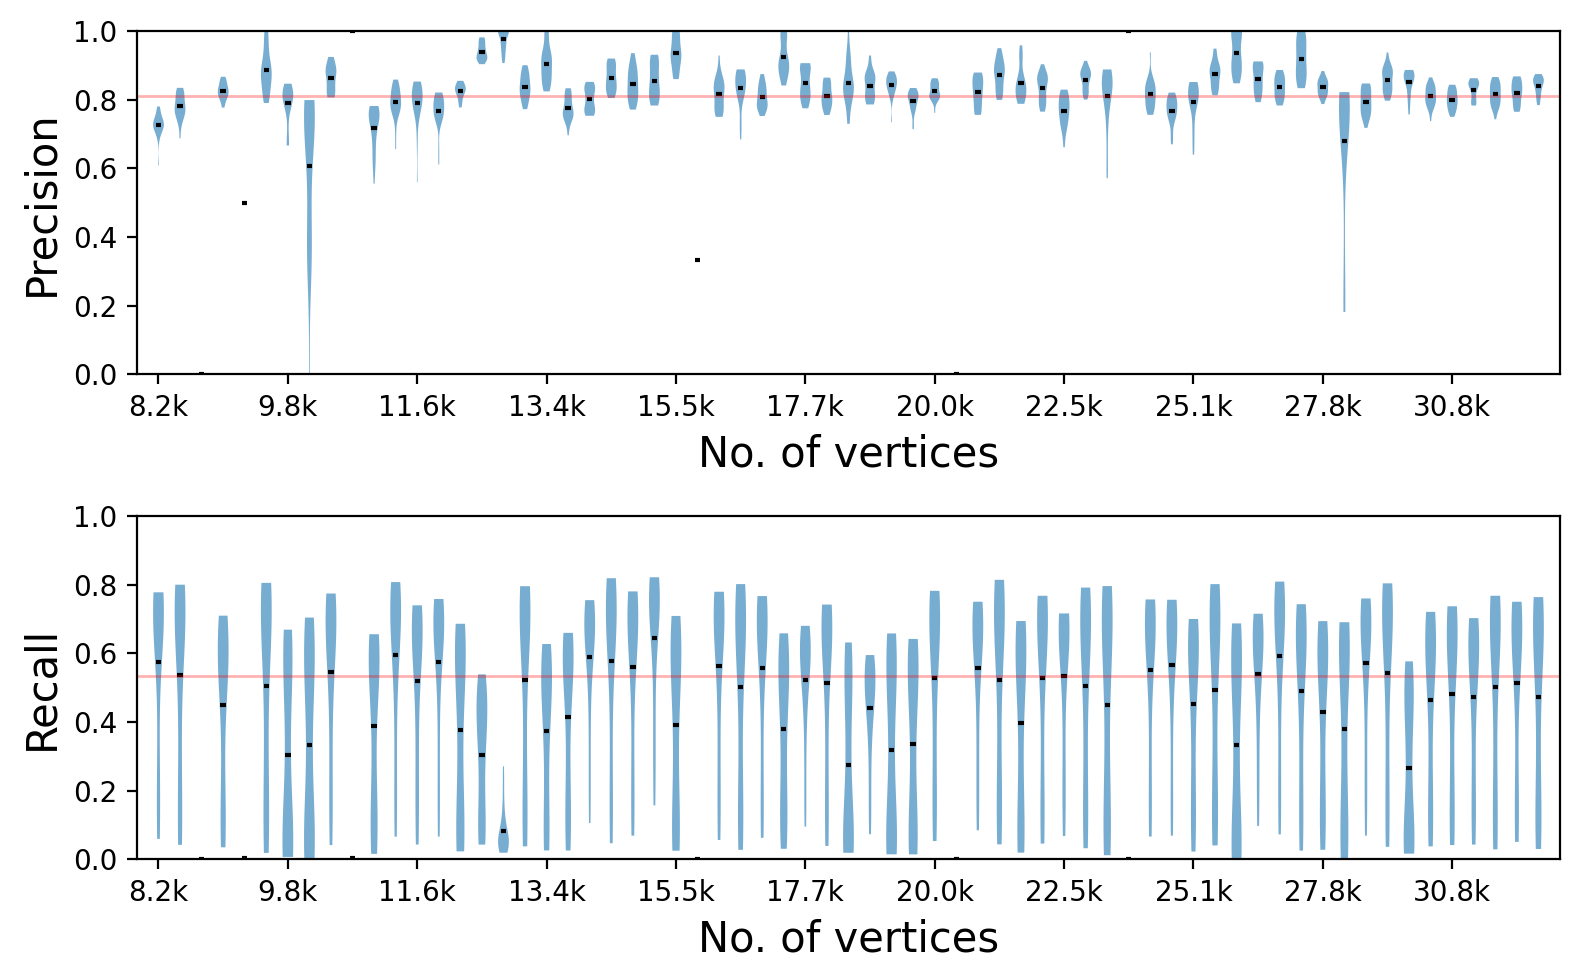

In [165]:
plt.figure(figsize=(8, 5), dpi=200)
plt.subplot(211)
# plt.boxplot(p, positions=res, vert=False, showmeans=True)
parts = plt.violinplot(p, showmeans=True, showextrema=False);
for pc in parts['bodies']:
    # pc.set_facecolor('#D43F3A')
    # pc.set_edgecolor('black')
    pc.set_alpha(0.6)
parts['cmeans'].set_color('black')
plt.ylabel('Precision', fontsize=15)
plt.xlabel("No. of vertices", fontsize=15)
plt.xticks(range(1, len(res)+1, 6),
           [f"{(el/1000):.1f}k" for el in res[0:-1:6]])
plt.xlim(0, 66)
plt.ylim(0, 1)
plt.hlines(np.mean(p, axis=0)[13], 0, 66, lw=1, alpha=0.3, color='red')

plt.subplot(212)
parts=plt.violinplot(r, showmeans=True, showextrema=False);
for pc in parts['bodies']:
    # pc.set_facecolor('#D43F3A')
    # pc.set_edgecolor('black')
    pc.set_alpha(0.6)
parts['cmeans'].set_color('black')
plt.ylabel('Recall', fontsize=15)
plt.xlabel("No. of vertices", fontsize=15)
plt.xticks(range(1, len(res)+1, 6),
           [f"{(el/1000):.1f}k" for el in res[0:-1:6]])
plt.xlim(0, 66)
plt.ylim(0, 1)
plt.hlines(np.mean(r, axis=0)[13], 0, 66, lw=1, alpha=0.3, color='red')

plt.tight_layout()

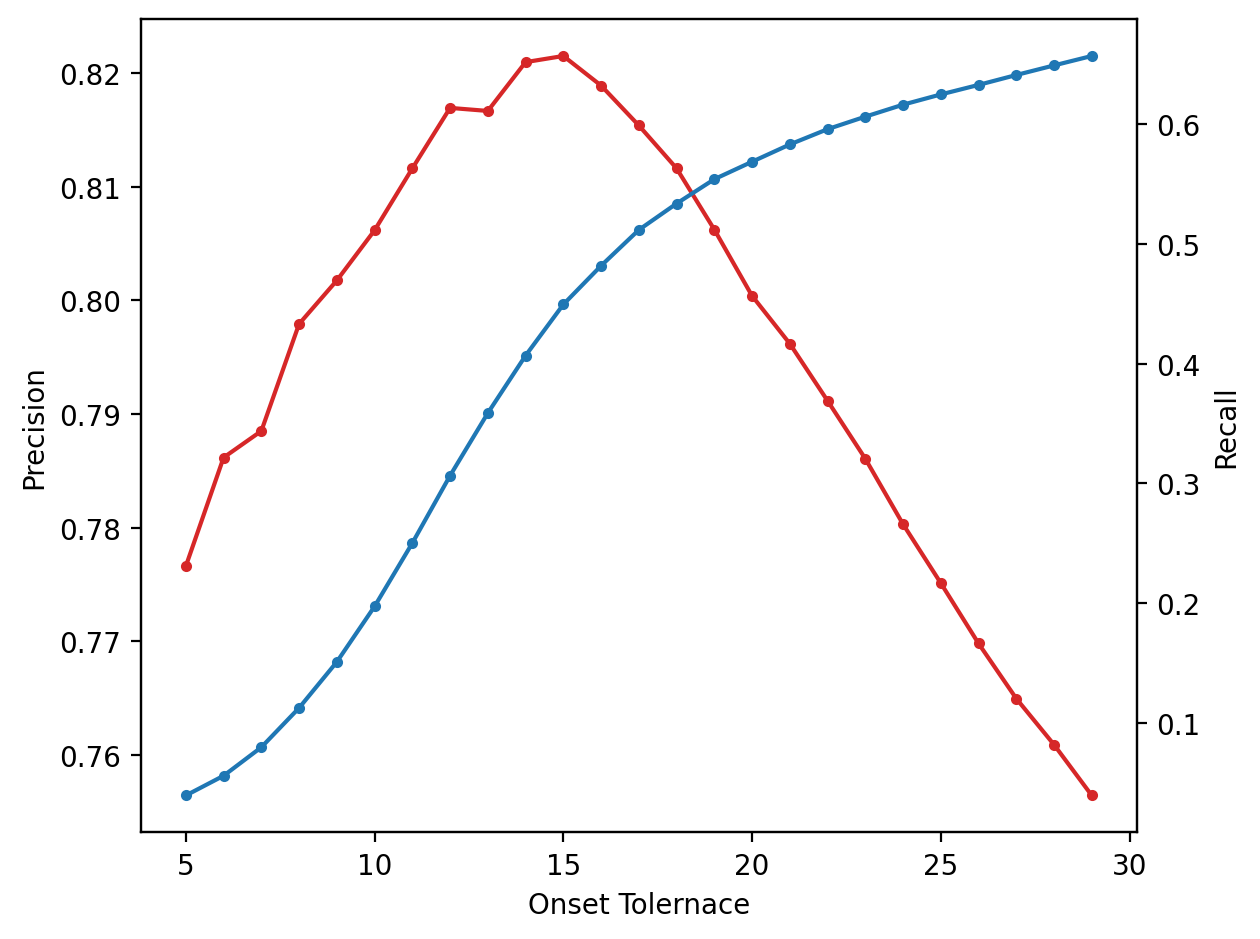

In [163]:
fig, ax1 = plt.subplots(dpi=200)

color = 'tab:red'
ax1.set_xlabel('Onset Tolernace')
ax1.set_ylabel('Precision')
ax1.plot(range(5, 30), np.mean(p, axis=0), color=color, marker='.')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Recall')
ax2.plot(range(5, 30), np.mean(r, axis=0), color=color, marker='.')


fig.tight_layout() 